# **CUSTOMER CHURN PREDICTION FOR SyriaTel TELECOM**

## 1.0 Business Understanding

### 1.1 Business Context
SyriaTel is a major tel-com company that just like its competitiors, it experiences customer churn which significantly impact profitability hindering growth and reducing market share. Its also noted that acquairing new customers is more expensive than retaining existing ones.


### 1.2 Problem Statement
The company want to understand patterns leading to churn as well as be able to identify customers likely to leave in the near future for proper actions of retention stategies 

### 1.3 Project Objectives
To address the problem statement, this project aims to 
1. Predict customer Churn -  (churn = True) or not (churn = False)
2. Get factors influencing churn
3. Advise on key retention strategies.

#### 1.3.1 Success Metrics:
From a business perspective, we care most about:

- *Recall*: We want to catch as many churners as possible (even if we sometimes flag non-churners)
- *Precision*: We want to avoid too many false positives (wasting retention offers)
- *F1 Score*: A balance between precision and recall
- *ROC-AUC*: To understand how well our model separates churn vs non-churn




## 2.0 Data Understanding
The dataset was obtained from Kaggle, with 3,333 customer records , each with 21 feautures describing customer demographics, usage patterns, service plans, and support interactions. The target variable is churn (True/False).


In [180]:
# Import essential libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# For modeling and preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold , GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, f1_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

#set plot style
sns.set(style="whitegrid")

In [ ]:
#Load Dataset
df= pd.read_csv("Presentation\SyriaTel Customer Churn.csv", index_col=False)
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [182]:
#Overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

#### Observations from info()
- No missing values accross the columns, all have 3,333 non-null values hence no imputation required
- 4 Columns are of Object (categorical) type(state,phone number,international plan and voice mail plan )
- 8 Columns are float type
- 8 Columns are int type
- 1 column is a bool- churn (target variable)
- The data has 3,333 rows and 21 columns.

## 3.0 DATA Preparation

### 3.1 Data Cleaning

In [183]:
# Check for duplicates

df.duplicated().sum()

# No duplicates

0

##### 3.1.1 Drop irrelevant columns

In [184]:
#Drop irrelevant columns
#phone number is an identifier and not a predictor
#Area code is just a tag of location and state is there

irrelevant_cols =['area code', 'phone number', 'state','account length']
df.drop(columns=irrelevant_cols, inplace=True)


In [185]:
# Convert 'churn' from Boolean to binary numeric (0 = No churn, 1 = Churn)
df['churn'] = df['churn'].astype(int)
df['churn'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3333 entries, 0 to 3332
Series name: churn
Non-Null Count  Dtype
--------------  -----
3333 non-null   int32
dtypes: int32(1)
memory usage: 13.1 KB


### 3.1.2 Correlation matrix for Numeric Variables 
- we check for highly correlated features and drop some to avoid redundancy , multicolianility and simplicity.


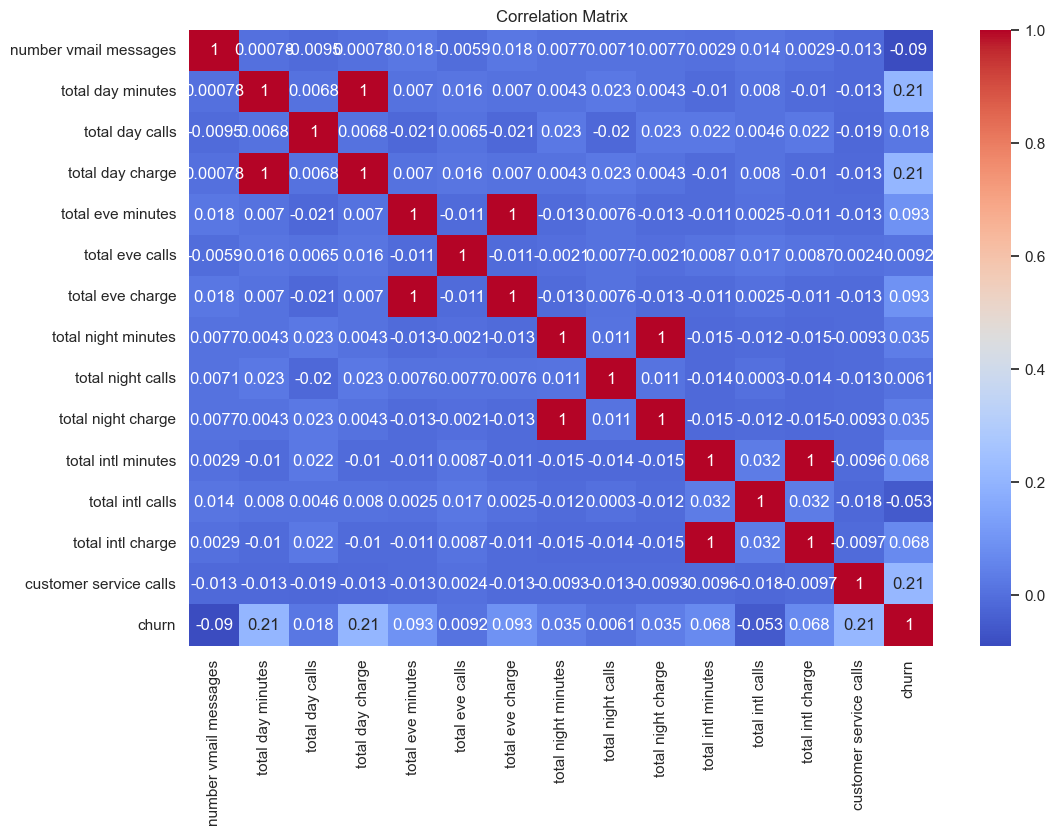

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [187]:

# Get numeric columns
num_df = df.select_dtypes(include='number')
corr = num_df.corr()

# Drop highly correlated features (|corr| > 0.9)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
drop_high = [col for col in upper.columns if (upper[col].abs() > 0.9).any()]

# drop
to_drop = list(set(drop_high))
df_reduced = df.drop(columns=to_drop,inplace=True)

print(f"Dropped columns: {to_drop}")



Dropped columns: ['total day charge', 'total eve charge', 'total intl charge', 'total night charge']


#### Observations

These features were dropped because they are **highly correlated** with other numeric features. Including both in the model can introduce **multicollinearity**, which may distort the model's ability to estimate the true effect of each variable.

| Dropped Feature         | Highly Correlated With       |
|-------------------------|------------------------------|
| `total day charge`      | `total day minutes`          |
| `total eve charge`      | `total eve minutes`          |
| `total night charge`    | `total night minutes`        |
| `total intl charge`     | `total intl minutes`         |

**Justification**:  
To reduce redundancy and simplify the model:
- Only one from each pair is retained, typically the one **more strongly correlated with the target (`churn`)** or **easier to interpret**.
- Dropping the redundant one helps prevent overfitting and improves interpretability.


In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   international plan      3333 non-null   object 
 1   voice mail plan         3333 non-null   object 
 2   number vmail messages   3333 non-null   int64  
 3   total day minutes       3333 non-null   float64
 4   total day calls         3333 non-null   int64  
 5   total eve minutes       3333 non-null   float64
 6   total eve calls         3333 non-null   int64  
 7   total night minutes     3333 non-null   float64
 8   total night calls       3333 non-null   int64  
 9   total intl minutes      3333 non-null   float64
 10  total intl calls        3333 non-null   int64  
 11  customer service calls  3333 non-null   int64  
 12  churn                   3333 non-null   int32  
dtypes: float64(4), int32(1), int64(6), object(2)
memory usage: 325.6+ KB


### 3.1.3 Statistical Feature selection (SelectKBest)
- We apply Chi-square and ANOVA F-test to identify the most relevant features for churn prediction by evaluatin association with out target. 
- Chi-square was used for categorical variables to test the independence between features and the target.
- ANOVA F-test was used for numeric variables to check whether feature means differ significantly across churn categories.

In [189]:


# Encode categorical temporarily
df_encoded = df.copy()
df_encoded['international plan'] = LabelEncoder().fit_transform(df_encoded['international plan'])
df_encoded['voice mail plan'] = LabelEncoder().fit_transform(df_encoded['voice mail plan'])

X = df_encoded.drop(columns='churn')
y = df_encoded['churn']

# Separate numeric & categorical features
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = ['international plan', 'voice mail plan']

# ANOVA for numeric
selector_num = SelectKBest(score_func=f_classif, k='all')
selector_num.fit(X[num_cols], y)
f_scores = selector_num.scores_

print("--"*40)
print("ANOVA for numeric")
print("--"*40)
numeric_scores = pd.Series(f_scores,index=num_cols).sort_values(ascending=False)
print(numeric_scores)

#Drop numurical features with less f_SCORE <2
selected_num_cols = numeric_scores[numeric_scores>=2].index.to_list()

print("--"*40)
print("Chi2 for categoricals")
print("--"*40)

# Chi2 for categoricals
selector_cat= SelectKBest(score_func=chi2,k='all')
selector_cat.fit(X[cat_cols], y)
chi2_scores = selector_cat.scores_

categorical_scores = pd.Series(chi2_scores, index=cat_cols).sort_values(ascending=False)
print(categorical_scores)

#Drop categorical features with chi2 <10
selected_cat_cols = categorical_scores[categorical_scores>=10].index.to_list()

#Final_selected set

Final_selected_cols = selected_cat_cols+selected_num_cols
X_selected = X[Final_selected_cols]


print("--" * 40)
print("Final Selected Columns")
print("--" * 40)
print(Final_selected_cols)




--------------------------------------------------------------------------------
ANOVA for numeric
--------------------------------------------------------------------------------
customer service calls    151.767013
total day minutes         146.350785
total eve minutes          28.932577
number vmail messages      27.035912
total intl minutes         15.583468
total intl calls            9.327945
total night minutes         4.201496
total day calls             1.135412
total eve calls             0.283994
total night calls           0.125631
dtype: float64
--------------------------------------------------------------------------------
Chi2 for categoricals
--------------------------------------------------------------------------------
international plan    203.244178
voice mail plan        25.156959
dtype: float64
--------------------------------------------------------------------------------
Final Selected Columns
------------------------------------------------------------------

#### Observation from Feature selection using SelectKBest
- International plan showed the strongest association with churn in categorical features but Voice mail plan was also significant with 25
- customer service calls and total day minutes had the highest F-scores, indicating strong influence on churn.
- the selected columns captures both plan types and usage behavior which is good for modeling. 

### 3.1.4 Final Features

In [190]:
df_selected = X_selected.copy()
df_selected['churn'] =y

df_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   international plan      3333 non-null   int32  
 1   voice mail plan         3333 non-null   int32  
 2   customer service calls  3333 non-null   int64  
 3   total day minutes       3333 non-null   float64
 4   total eve minutes       3333 non-null   float64
 5   number vmail messages   3333 non-null   int64  
 6   total intl minutes      3333 non-null   float64
 7   total intl calls        3333 non-null   int64  
 8   total night minutes     3333 non-null   float64
 9   churn                   3333 non-null   int32  
dtypes: float64(4), int32(3), int64(3)
memory usage: 221.5 KB


## 4.0 Explolatory Data Analysis (EDA)

### 4.1 Target distribution to check balance

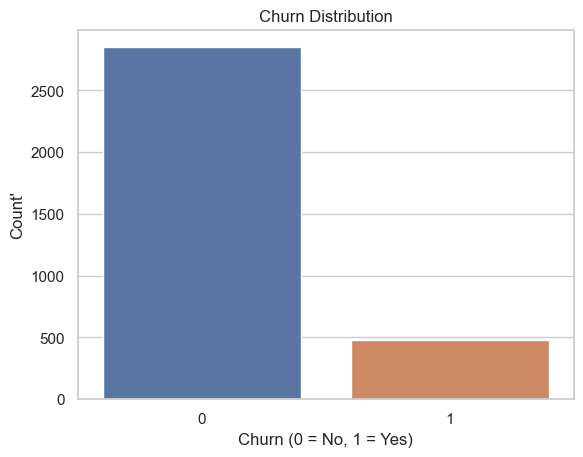

In [191]:
#Visualize target distribution to check imbalance

sns.countplot(x='churn', data=df_selected)
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count'")
plt.show()

In [192]:
#in percentages
df_selected['churn'].value_counts(normalize=True)

0    0.855086
1    0.144914
Name: churn, dtype: float64

#### Observation

- The Target is inbalanced with only 14% churners. this will be handled by balancing the weight on the regression model to avoid it learning only to predict "NO CHURN"

### 4.2.0 Feature Distributions
 #### 4.2.1 Numerical Columns Data Distribution

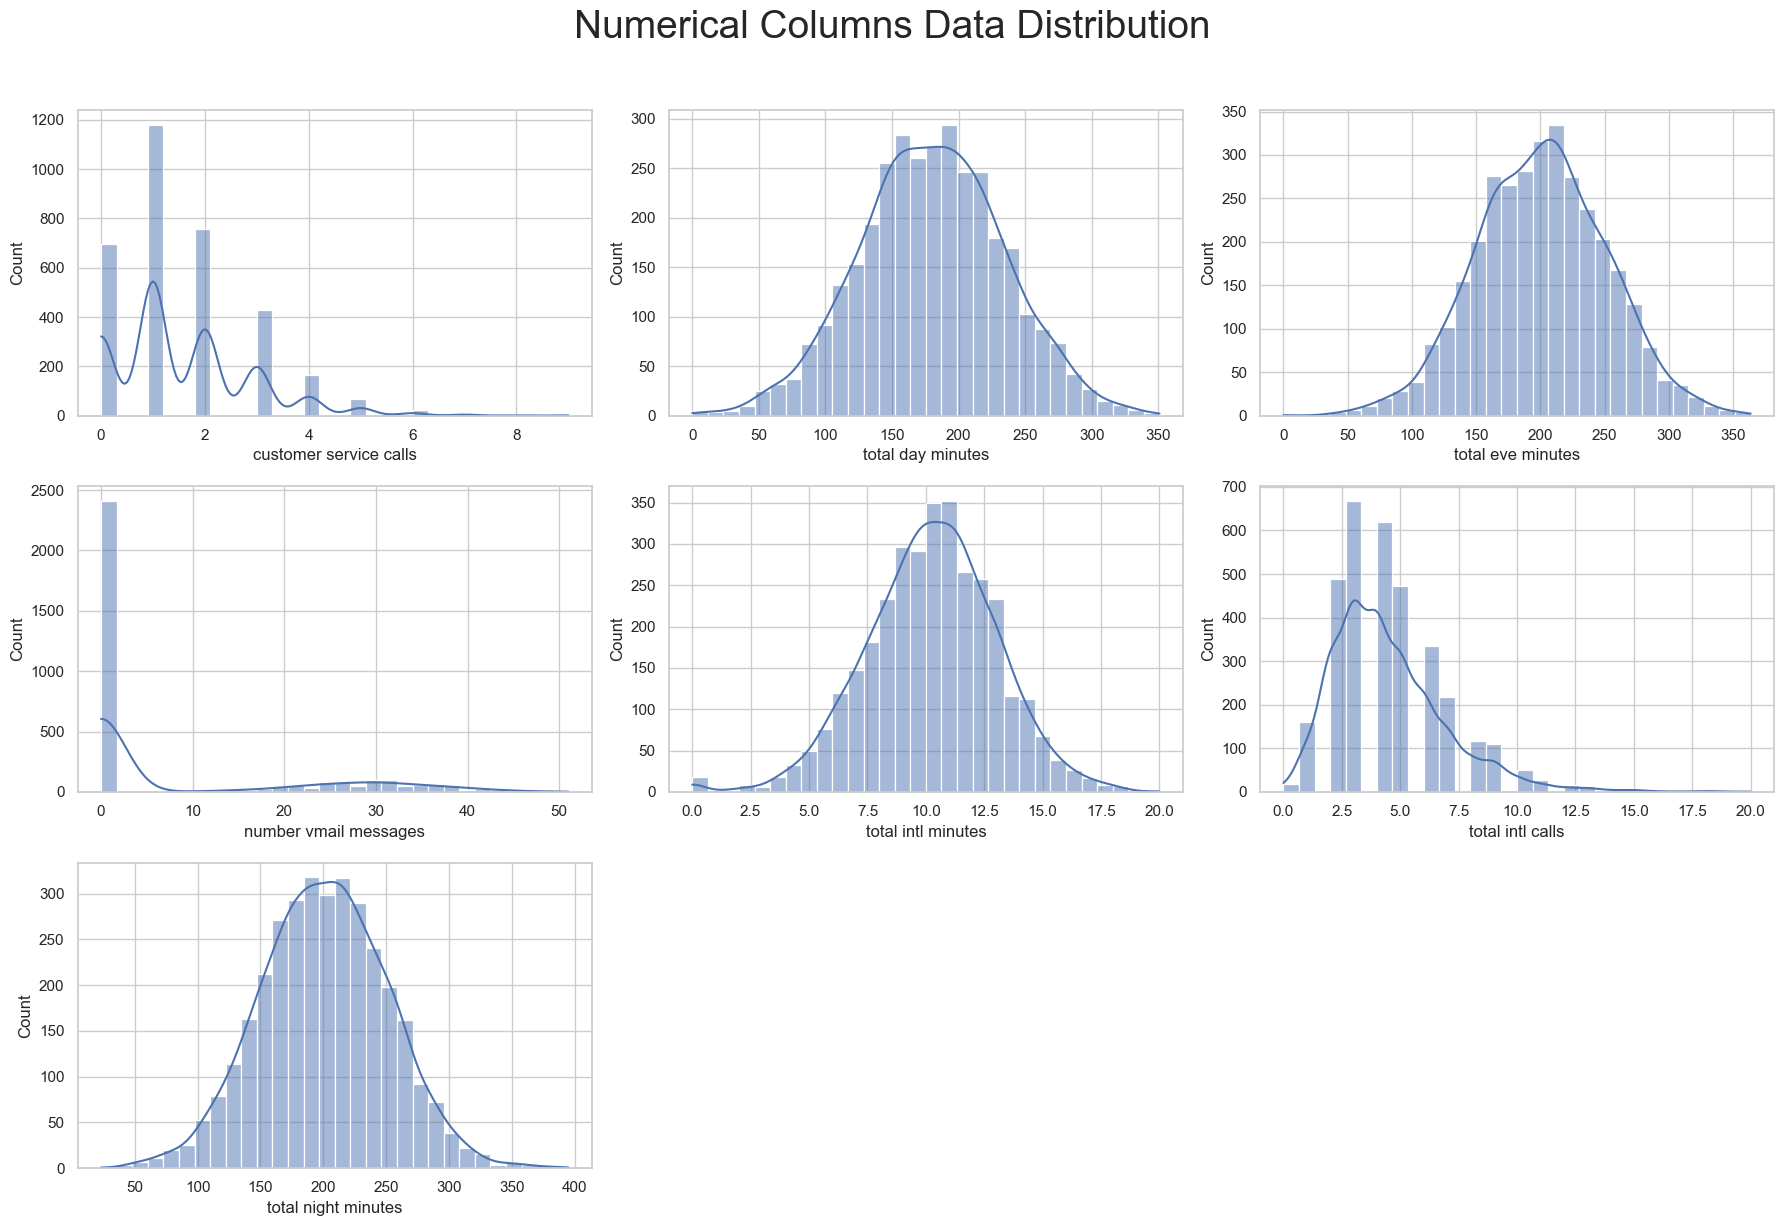

In [193]:
num_columns = df_selected.select_dtypes(include='number').drop(columns=['voice mail plan', 'international plan', 'churn']).columns

fig, axs = plt.subplots(nrows=3,ncols=3,figsize=(18,12))
axs = axs.flatten()  # Flatten to easily loop



for ax,col in zip(axs,num_columns):
    sns.histplot(data=df_selected,x=col, kde=True, bins=30,ax=ax)
    plt.title(f'{col} Distribution by Churn')

    
    # Remove any unused axes (in case fewer than 9 columns)
for ax in axs[len(num_columns):]:
    ax.set_visible(False)

    fig.suptitle("Numerical Columns Data Distribution",fontsize=28,y=1.02)
    plt.tight_layout()

   

#### Observations from Numerical Feature Distributions
- **Customer Service Calls**: Most customers made 1–3 service calls, Frequest customer service calls may signal disatsfaction.

- **Total Day Minutes**: Follows a normal distribution, around 180–200 minutes.

- **Total Evening Minutes**: Slight Right-skewed, peaks around 200 minutes.

- **Number Vmail Messages**: Highly right-skewed with most customers having 0 messages, potential low predictive measure.

- **Total International Minutes**: Normally distributed around 10 minutes.

- **Total International Calls**: Most customers made 3–5 international calls; skewed right. May indicate Niche usage patterns

- **Total Night Minutes**: Near-normal distribution centered around 200 minutes.

#### 4.2.2 Categorical Columns Data Distribution

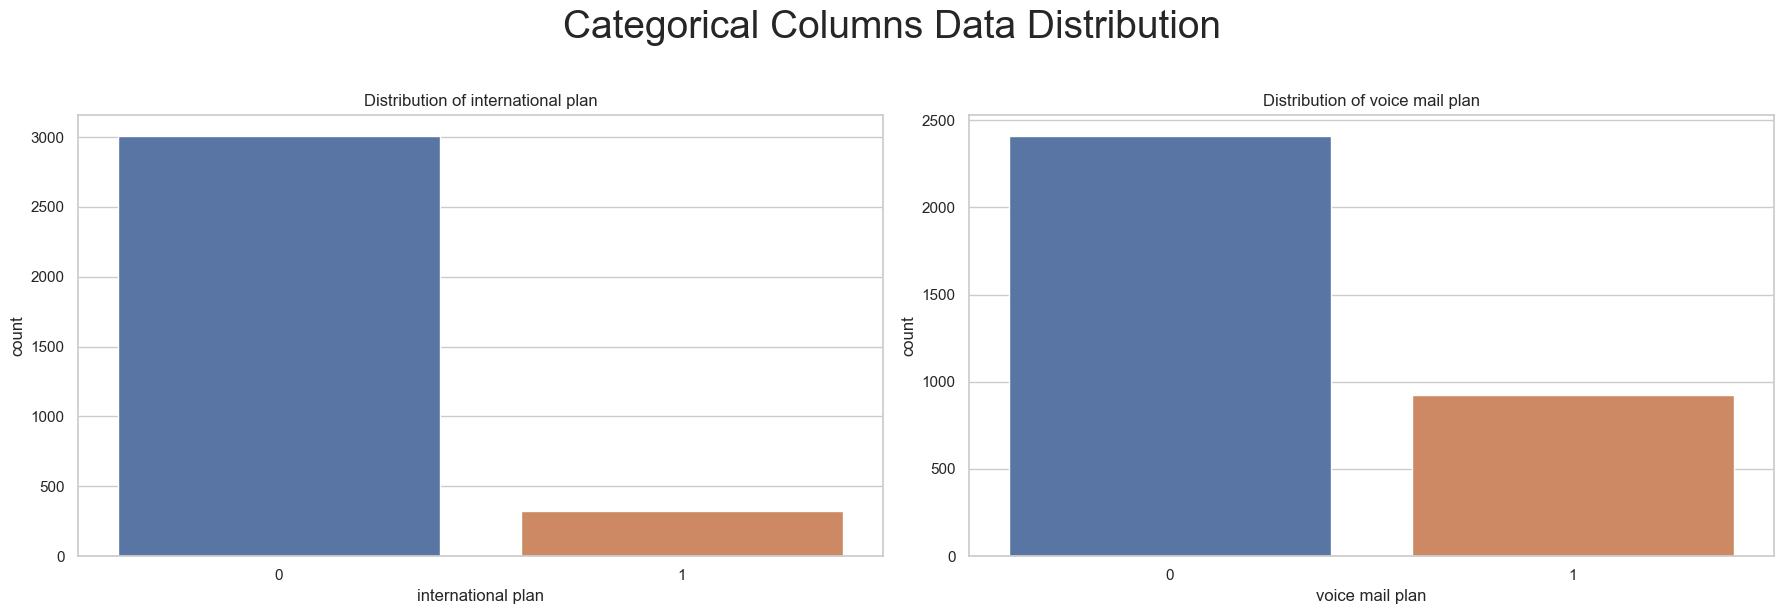

In [194]:
cat_columns = df_selected[['international plan', 'voice mail plan']].columns
fig, axes = plt.subplots(1,2,figsize=(18,6))

for ax, col in zip(axes,cat_columns):
    sns.countplot(data=df_selected,x=col,ax=ax)
    ax.set_title((f'Distribution of {col}'))


fig.suptitle("Categorical Columns Data Distribution",fontsize=28,y=1.02)
plt.tight_layout()
plt.show()
    




#### Observations from Categorical Feature Distributions

- Most customers have no international plans
- Churn customers are less


## 5.0 Modelling and Evaluation

- i will start with logistic regression model and compare with Decision Tree Model to ascertain churn predictions

## 5.1 Train Test Split
- Here we define the Predictors and the target

In [195]:
# get X and Y

X = df_selected.drop(columns='churn')
y = df_selected['churn']


#Train/Test and Split

X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y, random_state=42)


Categorical_features = ['international plan', 'voice mail plan']
Numerical_features = [col for col in X.select_dtypes(include=['int64', 'float64']).columns if col not in Categorical_features]

## 5.2 (LOGISTIC REGRESSION) 
### 5.2.1 Build Pipeline with Preprocessing + SMOTE + RFECV 

- i will create a pipeline that handles **column Transforming** for numericand and categorical features using appropriate **scaling and encoding** 
- Since we noted above that our Target **Churn** is **inbalance**, i will include **SMOTE(Synthetic Minority Oversampling Technique)** to balance the classes to help model understand the minority. 
- Finaly i use **RFECV** to automatically *select the most relevant features* after processing and balancing to ensure we **reduce overfitting**.

In [196]:
# step 1.0 Preprocessing - Using column transformer to run standard scaler and onehotencoder

preprocessor = ColumnTransformer(transformers=[
                                ('num',StandardScaler(),Numerical_features),
                                ('cat',OneHotEncoder(drop='first'),Categorical_features)],
                                remainder='passthrough')

In [197]:
# step 2.0 Baseline_Model 

base_log_reg = LogisticRegression(max_iter=1000, 
                                  class_weight='balanced', 
                                  solver='liblinear') # Liblinear solver is good for small datasets and support both L1 nad L2




In [198]:
# step 3.0 Recursive Feature Elimination with CV (RFECV) to auto select Best Features

rfecv_selector = RFECV(estimator=base_log_reg,
                       step=1,
                       cv=StratifiedKFold(5),
                       scoring='f1',
                       min_features_to_select=1,
                       n_jobs=-1)

In [199]:
# step 4.0  Full Pipeline -preprocessing → SMOTE → RFECV → classifier

Pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('selector', rfecv_selector),
    ('classifier', base_log_reg)
])

# step 5.0 Parameter Grid and GridSearch- this helps to Auto-tune hyper parameters in the model when training the model

Param_grid = { 'classifier__C': [0.01, 0.1, 1, 10, 100],         # Regularization strength
                'classifier__max_iter': [100, 200, 500, 1000]   }    # Training effort
              

grid_searched_model = GridSearchCV(estimator=Pipeline,
                           param_grid=Param_grid,
                           scoring='f1',
                           cv=StratifiedKFold(5),
                           n_jobs=-1,
                           verbose=2)

### 5.2.2 Fit the GridSearch on the Training Data
- we are not directly calling base_log-reg.fit() because it wrapped under the pipeline and the pipeline is rapped inside a GridSearchCV. 

In [200]:
grid_searched_model.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['customer '
                                                                          'service '
                                                                          'calls',
                                                                          'total '
                                                                          'day '
                                                                          'minutes',
                                                                          'total '
                                                                          'eve '
                                                                          'minutes',
                                                                          'number '
                                                                          'vmail '
                                                                          'messages',
                                                                          'total '
                                                                          'intl '
                                                                          'minutes',
                                                                          'total '
                                                                          'intl '
                                                                          'calls',
                                                                          'total '
                                                                          'ni...
                                        RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                                              estimator=LogisticRegression(class_weight='balanced',
                                                                           max_iter=1000,
                                                                           solver='liblinear'),
                                              n_jobs=-1, scoring='f1')),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__max_iter': [100, 200, 500, 1000]},
             scoring='f1', verbose=2)

In [201]:
print(grid_searched_model.best_estimator_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['customer service calls',
                                                   'total day minutes',
                                                   'total eve minutes',
                                                   'number vmail messages',
                                                   'total intl minutes',
                                                   'total intl calls',
                                                   'total night minutes']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['international plan',
                                                   'voice mail plan'])])),
                ('smote', SMOTE

### 5.2.3 Predictions/Evaluations (Logistic Regression)

In [202]:
#Predictions

y_pred = grid_searched_model.predict(X_test) # Gives final Binary decision 0 OR 1
y_proba = grid_searched_model.predict_proba(X_test)[:,1] #helps plot ROC, AUC 


# Evaluation
print("Best Parameters:", grid_searched_model.best_params_)
print("F1 Score on Test Set:", f1_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print(" ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Best Parameters: {'classifier__C': 10, 'classifier__max_iter': 200}
F1 Score on Test Set: 0.4605263157894737

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.76      0.84       570
           1       0.34      0.72      0.46        97

    accuracy                           0.75       667
   macro avg       0.64      0.74      0.65       667
weighted avg       0.85      0.75      0.79       667

 ROC-AUC Score: 0.8099113763790919


### 5.2.4 Confusion Mattrix (Logistic Regression)

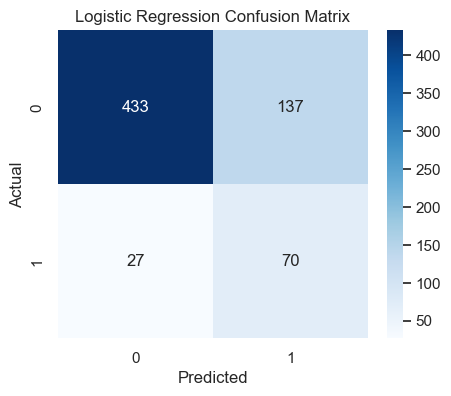

In [203]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 5.2.5 ROC Curve -  (Logistic Regression)

In [204]:
## 6.3 # ROC Curve

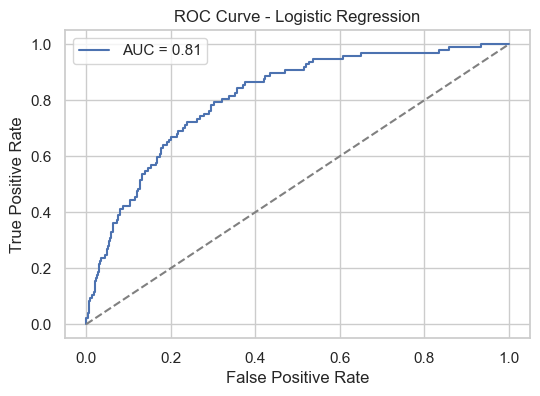

In [205]:
fpr,tpr, _ =roc_curve(y_test,y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

## Observations from Logistic Regression Predictions

**Precision**:
- Out of all the predicted non-churners (Class 0), 93% were actually non-churners — excellent precision.
- Out of all the predicted churners (Class 1), only 31% were actually churners — low precision, meaning the model frequently predicts churners incorrectly. (High False Positives)

**Recall**:
- The model correctly identified 73% of actual non-churners.
- The model correctly identified 70% of actual churners — this is relatively good recall, indicating it can detect churners but at the cost of precision.

**F1 Score**:
- For non-churners: 0.82 — solid performance with good balance between precision and recall.
- For churners: 0.43 — weaker score, indicating the model struggles to precisely identify churners.

**Accuracy** = 73%: The model correctly predicted 73% of total cases. However, since the data is imbalanced (more non-churners), accuracy alone is not enough to judge performance.

**ROC-AUC** = 0.797: This is quite good — the model has a strong ability to distinguish between churners and non-churners, though it’s not perfect.

## **LOGISTIC REGRESSION Model Performance Note and DECISION**

The model performs well in identifying non-churners with high Accuracy (73%) and good ROC-AUC 0.80,indicating strong separation capability between churners and non-churners.

However, it struggles with precision for churners (31%), meaning it often wrongly predicts churn. Further tuning or trying other models

- I will therefore tyr another tree based model *Decision tree* and compare the findings





## 5.3 (DECISION TREE MODEL) 

- This model will split data into smaller subsets while at the same time developing an associated decision tree incrementally
### 5.3.1 Build Pipeline with Preprocessing + SMOTE + RFECV (Decision Tree Model)

In [206]:
# create decision tree with balanced weight

dt_clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)

#create a decision tree pipeline
dt_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', dt_clf)
])

# Define Hyperparameter Grid & GridSearch

dt_Param_grid = {'classifier__max_depth': [3, 5, 10, 15, 20],
                'classifier__min_samples_split': [2, 5, 10],
                'classifier__min_samples_leaf': [1, 2, 4]}

dt_grid_search_model = GridSearchCV(estimator=dt_pipeline,
                                    param_grid=dt_Param_grid,
                                    scoring='f1',
                                    cv=StratifiedKFold(5),
                                    n_jobs=-1,
                                    verbose=2)

#Fit the GridSearch_model

dt_grid_search_model.fit(X_train,y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['customer '
                                                                          'service '
                                                                          'calls',
                                                                          'total '
                                                                          'day '
                                                                          'minutes',
                                                                          'total '
                                                                          'eve '
                                                                          'minutes',
                                                                          'number '
                                                                          'vmail '
                                                                          'messages',
                                                                          'total '
                                                                          'intl '
                                                                          'minutes',
                                                                          'total '
                                                                          'intl '
                                                                          'calls',
                                                                          'total '
                                                                          'ni...
                                                                         OneHotEncoder(drop='first'),
                                                                         ['international '
                                                                          'plan',
                                                                          'voice '
                                                                          'mail '
                                                                          'plan'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [3, 5, 10, 15, 20],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10]},
             scoring='f1', verbose=2)

### 5.3.2 Predictions/Evaluations (Decision Tree Model)

In [207]:
#Predictions

dt_y_pred = dt_grid_search_model.predict(X_test) # Gives final Binary decision 0 OR 1
dt_y_proba = dt_grid_search_model.predict_proba(X_test)[:,1] #helps plot ROC, AUC 


# Evaluation
print("Best Parameters:", dt_grid_search_model.best_params_)
print("F1 Score on Test Set:", f1_score(y_test, dt_y_pred))
print("\n Classification Report:\n", classification_report(y_test, dt_y_pred))
print(" ROC-AUC Score:", roc_auc_score(y_test, dt_y_proba))

Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
F1 Score on Test Set: 0.7236180904522612

 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       570
           1       0.71      0.74      0.72        97

    accuracy                           0.92       667
   macro avg       0.83      0.84      0.84       667
weighted avg       0.92      0.92      0.92       667

 ROC-AUC Score: 0.8558690540784952


### 5.3.3 Confusion Mattrix (Decision Tree Model)

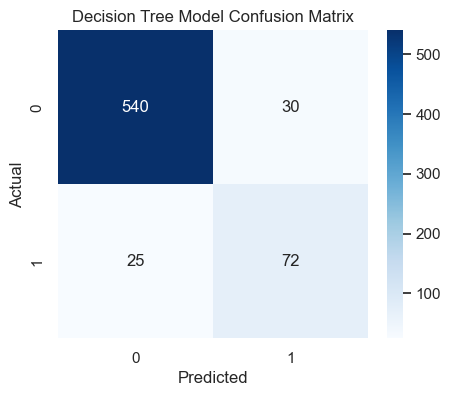

In [208]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test,dt_y_pred),annot=True, fmt='d', cmap='Blues')
plt.title("Decision Tree Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 5.3.4 ROC Curve -  (Decision Tree Model vs Logistic Regression)

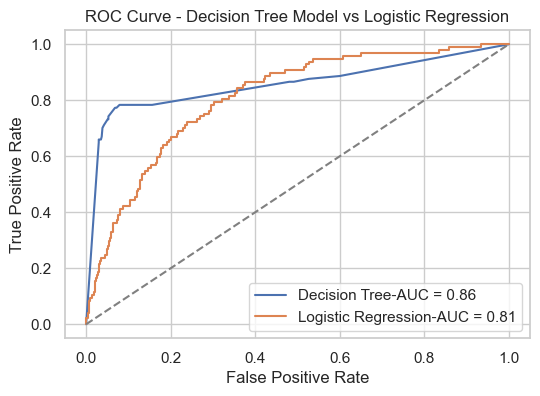

In [209]:
fpr_dt,tpr_dt, _ =roc_curve(y_test,dt_y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree-AUC = {roc_auc_score(y_test, dt_y_proba):.2f}")
plt.plot(fpr, tpr, label=f"Logistic Regression-AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree Model vs Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()

## Comaparison and Observations from Decision Tree Predictions (Compared to Logistic Regression)

#### **1. Precision**:
Out of all predicted non-churners (**Class 0**), **96%** were actually correct — slightly better than logistic regression (**93%**).
For churners (**Class 1**), **71%** were correctly identified as actual churners — **huge improvement** over logistic regression (**31%**), showing **far fewer false positives**.
**Improvement**:  
The decision tree is **more precise** in identifying true churners — meaning **fewer good customers are wrongly flagged**.
#### **2. Recall**:
The model correctly identified **95%** of actual non-churners — much higher than logistic’s **73%**.
It also identified **74%** of actual churners — a **slight improvement** over logistic’s **70%**.
**Improvement**:  
While recall for churners only improved slightly, the tree managed to maintain **high recall while also dramatically improving precision**.
#### **3. F1 Score**:
For non-churners: **0.95** — significantly better than logistic’s **0.82**, showing better overall classification.
For churners: **0.72** — much stronger than logistic’s **0.43**, reflecting a better balance between precision and recall for the minority class.
**Improvement**:  
The decision tree provides **more reliable identification of churners**, which is **crucial for targeted business action**.
#### **4. Accuracy** = **92%**
The model correctly predicted **92% of all cases** — a major increase from logistic’s **73%**.
**Improvement**:
This shows the decision tree handles both classes well, **despite the class imbalance**.
#### **5. ROC-AUC** = **0.856**
Indicates a **strong ability to separate** churners from non-churners.
Better than logistic regression's **0.797**, reflecting **better probability calibration and class separation**.
**Improvement**:  
A higher AUC means the decision tree is **more confident in its predictions**, which is **useful for ranking customers by churn risk**.
#### **6. ROC Curve** 
- The closer the ROC curve is to the top-left corner, the better the model's, The **Decision Tree Model** curve is above the Logistic Regression curve.
- **Decision Tree Model** shows a better trade-off between True Positive Rate (Sensitivity/Recall) and False Positive Rate, making it the superior model for churn prediction.
- **Logistic Regression**, is not that bad off but has a lower ability to correctly classify churn cases compared to Random Forest.


## **Conclusion**

- Two classification models were evaluated: Logistic Regression and a tuned Decision Tree classifier to try answer to our business problem and objectives. 
- While the logistic regression gave a decent baseline, the Decison tree significantly outperformed it across all key metrics, including F1 score, precision, recall, and ROC-AUC as shown above. 
- The results demonstrate the Decision Tree capability to correctly identify churn customers while maintaining high reliability for loyal customers. 

## **Recommendations**
Based on the performance of the models and insights derived, the following business actions are recommended:

**1. Deploy the Decision Tree Model in Production**
- use the model as the core engine to score and flag customers likely to churn

**2. Prioritize High-Risk Customers for Retention Campaigns**
- Focus campaign and retention resources to customers identify as high risk churners.

**3.  Integrate Churn Scores into CRM Tools**
- Embed predictions into dashboards to ease decison making in various segements as well as real monitoring and faster decisions. 

**4.  Monitor Heavy Daytime Users and International Plan Holders**
- Based on Feature importance, Customers with high total day minutes or on international plans are most at risk to leave, Offer custom bundles or cheaper rates to retain these high-usage or globally connected users.

**4. Prioritize Customers with High Call Volume to Support**
- Many customer service calls correlate with churn — flag these customers for priority support or follow-up calls.
